In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pyabf
import glob
import seaborn as sns
import pandas as pd
import os
import scipy.stats as stats

In [17]:
def baseline_sweep(abf):
    #baseline based on the slope
    baseline = np.mean(abf.sweepY)
    data_out = abf.sweepY - baseline
    return data_out


In [18]:
MAIN_FOLDER = "Z:\\Molsrv\\Julia\\Data\\Opto\\Opto Perifornical for Grant_2025\\ALL FILES"
xlsx_files = glob.glob(MAIN_FOLDER + "\\*.xlsx")
all_results = {}
PRE_TIME = (1.027*1000, 1.047*1000)
POST_TIME = (1.047*1000, 1.062*1000)
col_map = {0: "sweep", 4: "event_time", 7:"peak_amp"}
col_map_inv = {v: k for k, v in col_map.items()}
RAW_DATA = {}
for fe in xlsx_files:
    if "~$" in fe:
        continue
    df = pd.read_excel(fe, header=None)
    
    df.rename(columns=col_map, inplace=True)
    print(f"Processing {fe} with {len(df)} rows")
    #get the filename without extension
    filename = os.path.splitext(os.path.basename(fe))[0]
    



    if os.path.exists(os.path.join(MAIN_FOLDER, filename + ".abf")):
        abf = pyabf.ABF(os.path.join(MAIN_FOLDER, filename + ".abf"), loadData=False)
        print(f"Loaded {abf.abfID} with {abf.sweepCount} sweeps")
        #actually load it
        abf = pyabf.ABF(os.path.join(MAIN_FOLDER, filename + ".abf"))
        



    else: 
        print(f"!!!!!       ABF file for {filename} not found, skipping !!!!!!!!!!!!!!!!!!!!!!!")
        break
    if df.empty:
        #fill everything with zeros
        unested_results = {
            "filename": filename,
            "abfID": None,
            "sweepCount": 0,
            "pre_count_mean": 0,
            "post_count_mean": 0,
            "pre_count_std": 0,
            "post_count_std": 0,
        }
        unested_results.update({'p': 1.0, 'stat': 0})
        pre_columns = {f"PRE_{i}": 0 for i in range(abf.sweepCount)}
        post_columns = {f"POST_{i}": 0 for i in range(abf.sweepCount)}


        all_results[fe] = unested_results
        RAW_DATA[fe] = np.array([])
        continue
    results = {"Pre": [], "Post": [], 'max': []}
    for sweep in np.arange(abf.sweepCount):
        #get that sweep from the df
        sweep_df = df[df["sweep"] == sweep]
        #filter events smaller than -5 pA
        sweep_df = sweep_df[sweep_df["peak_amp"] < -5]
        abf.setSweep(sweep)
        idx_start = np.argmin(np.abs(abf.sweepX - POST_TIME[0]/1000))
        idx_end = np.argmin(np.abs(abf.sweepX - POST_TIME[1]/1000))
        sweep_baselined = baseline_sweep(abf)
        if not sweep_df.empty:
            event_time = sweep_df["event_time"].values
            #get the count of events pre and post
            pre_count = np.sum(np.logical_and(event_time >= PRE_TIME[0], event_time < PRE_TIME[1]))
            post_count = np.sum(np.logical_and(event_time >= POST_TIME[0], event_time < POST_TIME[1]))
            results["Pre"].append(pre_count)
            results["Post"].append(post_count)
            #get the peak (negative amp)
            max_peak = np.min(sweep_baselined[idx_start:idx_end])
            
            results["max"].append(max_peak)


        else:
            results["Pre"].append(0)
            results["Post"].append(0)
            max_peak = np.min(sweep_baselined[idx_start:idx_end])
            results["max"].append(max_peak)

    #run wilcoxon test
    #special case if all zero
    if all(x == 0 for x in results["Pre"]) and all(x == 0 for x in results["Post"]):
        print(f"All zero counts for {fe}, skipping Wilcoxon test")
        stat, p = 0, 1.0
    else:
        stat, p = stats.wilcoxon(results["Pre"], results["Post"], zero_method="pratt", alternative="less")
    print(f"Wilcoxon test results for {fe}: stat={stat}, p={p}")
    results["stat"] = stat
    results["p"] = p

    unested_results = {k: v for k, v in results.items() if k != "Pre" and k != "Post"}
    unested_results.update({
        "filename": filename,
        "abfID": abf.abfID,
        "sweepCount": abf.sweepCount,
        "pr_count_mean": np.mean(results["Pre"]),
        "pos_count_mean": np.mean(results["Post"]),
        "pr_count_std": np.std(results["Pre"]),
        "pos_count_std": np.std(results["Post"]),
        "pr_count_tot": np.sum(results["Pre"]),
        "pos_count_tot": np.sum(results["Post"]),
        "mean_peak": np.mean(results["max"]),


    })
    pre_columns = {f"PRE_{i}": v for i, v in enumerate(results["Pre"])}
    post_columns = {f"POST_{i}": v for i, v in enumerate(results["Post"])}
    all_results[fe] = {**unested_results, **pre_columns, **post_columns}

    RAW_DATA[fe] = df[["sweep", "event_time"]].to_numpy()



Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0003.xlsx with 20 rows
Loaded 2025_08_06_0003 with 18 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0003.xlsx: stat=62.0, p=0.7928919108787373
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0007.xlsx with 80 rows
Loaded 2025_08_06_0007 with 19 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0007.xlsx: stat=104.5, p=0.9166174601411015
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0018.xlsx with 1 rows
Loaded 2025_08_06_0018 with 5 sweeps
All zero counts for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0018.xlsx, skipping Wilcoxon test
Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0018.xlsx: stat=0, p=1.0
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0054.xlsx with 40 rows
Loaded 2025_08_06_0054 with 18 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0054.xlsx: stat=32.0, p=0.32736042300928847
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0060.xlsx with 8 rows
Loaded 2025_08_06_0060 with 25 sweeps
All zero counts for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0060.xlsx, skipping Wilcoxon test
Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0060.xlsx: stat=0, p=1.0
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0062.xlsx with 66 rows
Loaded 2025_08_06_0062 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0062.xlsx: stat=156.0, p=0.8758934605050381
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0066.xlsx with 88 rows
Loaded 2025_08_06_0066 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0066.xlsx: stat=122.0, p=0.7253339447172669
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0074.xlsx with 85 rows
Loaded 2025_08_06_0074 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0074.xlsx: stat=126.0, p=0.8413447460685429
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0077.xlsx with 39 rows
Loaded 2025_08_06_0077 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0077.xlsx: stat=0.0, p=0.0004866644473084033
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0083.xlsx with 48 rows
Loaded 2025_08_06_0083 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0083.xlsx: stat=36.0, p=0.0022543491824521134
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0087.xlsx with 23 rows
Loaded 2025_08_06_0087 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0087.xlsx: stat=46.0, p=0.32736042300928847
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0014.xlsx with 42 rows
Loaded 2025_08_07_0014 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0014.xlsx: stat=136.5, p=0.7181485691746134
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0018.xlsx with 16 rows
Loaded 2025_08_07_0018 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0018.xlsx: stat=24.0, p=0.28185143082538655
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0021.xlsx with 45 rows
Loaded 2025_08_07_0021 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0021.xlsx: stat=63.0, p=0.15865525393145707
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0026.xlsx with 7 rows
Loaded 2025_08_07_0026 with 18 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0026.xlsx: stat=17.5, p=0.5
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0029.xlsx with 15 rows
Loaded 2025_08_07_0029 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0029.xlsx: stat=25.0, p=0.8413447460685429
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0044.xlsx with 40 rows
Loaded 2025_08_07_0044 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0044.xlsx: stat=69.0, p=0.6726395769907115
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0047.xlsx with 129 rows
Loaded 2025_08_07_0047 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0047.xlsx: stat=0.0, p=5.614510044731545e-06
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0050.xlsx with 17 rows
Loaded 2025_08_07_0050 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0050.xlsx: stat=24.0, p=0.28185143082538655
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0059.xlsx with 16 rows
Loaded 2025_08_07_0059 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0059.xlsx: stat=25.0, p=0.8413447460685429
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0062.xlsx with 31 rows
Loaded 2025_08_07_0062 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0062.xlsx: stat=39.0, p=0.01641844540669354
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0066.xlsx with 96 rows
Loaded 2025_08_07_0066 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0066.xlsx: stat=0.0, p=1.607977781600331e-05
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0070.xlsx with 42 rows
Loaded 2025_08_07_0070 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0070.xlsx: stat=92.0, p=0.9101437525605001
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0073.xlsx with 33 rows
Loaded 2025_08_07_0073 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0073.xlsx: stat=0.0, p=4.816785043215445e-07
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0077.xlsx with 80 rows
Loaded 2025_08_07_0077 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0077.xlsx: stat=15.0, p=9.287462566905973e-05
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0080.xlsx with 9 rows
Loaded 2025_08_07_0080 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0080.xlsx: stat=49.0, p=0.9213503964748574
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0010.xlsx with 4 rows
Loaded 2025_08_11_0010 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0010.xlsx: stat=24.5, p=0.5
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0013.xlsx with 9 rows
Loaded 2025_08_11_0013 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0013.xlsx: stat=24.5, p=0.5
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0016.xlsx with 18 rows
Loaded 2025_08_11_0016 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0016.xlsx: stat=45.0, p=0.2071080891212626
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0023.xlsx with 16 rows
Loaded 2025_08_11_0023 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0023.xlsx: stat=49.0, p=0.9213503964748574
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0043.xlsx with 25 rows
Loaded 2025_08_11_0043 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0043.xlsx: stat=67.5, p=0.5
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0047.xlsx with 39 rows
Loaded 2025_08_11_0047 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0047.xlsx: stat=90.0, p=0.7928919108787373
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0054.xlsx with 3 rows
Loaded 2025_08_11_0054 with 25 sweeps
All zero counts for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0054.xlsx, skipping Wilcoxon test
Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0054.xlsx: stat=0, p=1.0
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0057.xlsx with 44 rows
Loaded 2025_08_11_0057 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0057.xlsx: stat=42.0, p=0.0477903522728147
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0059.xlsx with 7 rows
Loaded 2025_08_11_0059 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_11_0059.xlsx: stat=24.5, p=0.5
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0014.xlsx with 6 rows
Loaded 2025_08_12_0014 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0014.xlsx: stat=48.0, p=0.7181485691746134
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0023.xlsx with 51 rows
Loaded 2025_08_12_0023 with 21 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0023.xlsx: stat=89.0, p=0.6869609903610802
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0027.xlsx with 166 rows
Loaded 2025_08_12_0027 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0027.xlsx: stat=117.0, p=0.1658773982840996
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0031.xlsx with 46 rows
Loaded 2025_08_12_0031 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0031.xlsx: stat=123.0, p=0.736455371567231
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0034.xlsx with 20 rows
Loaded 2025_08_12_0034 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0034.xlsx: stat=48.0, p=0.7181485691746134
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0037.xlsx with 144 rows
Loaded 2025_08_12_0037 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0037.xlsx: stat=23.0, p=0.0002478318622508009
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0039.xlsx with 22 rows
Loaded 2025_08_12_0039 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0039.xlsx: stat=20.5, p=0.005706018193000826
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0043.xlsx with 80 rows
Loaded 2025_08_12_0043 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0043.xlsx: stat=180.0, p=0.96776725996109
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0047.xlsx with 45 rows
Loaded 2025_08_12_0047 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0047.xlsx: stat=171.0, p=0.9172410706512649
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0073.xlsx with 15 rows
Loaded 2025_08_12_0073 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0073.xlsx: stat=49.0, p=0.9213503964748574
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0076.xlsx with 0 rows
Loaded 2025_08_12_0076 with 25 sweeps
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0079.xlsx with 3 rows
Loaded 2025_08_12_0079 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0079.xlsx: stat=49.0, p=0.9213503964748574
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0082.xlsx with 12 rows
Loaded 2025_08_12_0082 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_12_0082.xlsx: stat=49.0, p=0.9213503964748574
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0018.xlsx with 20 rows
Loaded 2025_08_13_0018 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0018.xlsx: stat=0.0, p=0.0416322583317752
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0025.xlsx with 8 rows
Loaded 2025_08_13_0025 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0025.xlsx: stat=24.0, p=0.28185143082538655
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0032.xlsx with 15 rows
Loaded 2025_08_13_0032 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0032.xlsx: stat=112.5, p=0.9487647825701253
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0043.xlsx with 6 rows
Loaded 2025_08_13_0043 with 25 sweeps
All zero counts for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0043.xlsx, skipping Wilcoxon test
Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0043.xlsx: stat=0, p=1.0
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0046.xlsx with 1 rows
Loaded 2025_08_13_0046 with 25 sweeps
All zero counts for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0046.xlsx, skipping Wilcoxon test
Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0046.xlsx: stat=0, p=1.0
Processing Z:\Mols

c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0049.xlsx: stat=49.0, p=0.9213503964748574
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0052.xlsx with 9 rows
Loaded 2025_08_13_0052 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0052.xlsx: stat=46.0, p=0.32736042300928847
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0054.xlsx with 52 rows
Loaded 2025_08_13_0054 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0054.xlsx: stat=171.0, p=0.9172410706512649
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0058.xlsx with 7 rows
Loaded 2025_08_13_0058 with 25 sweeps
All zero counts for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0058.xlsx, skipping Wilcoxon test
Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_13_0058.xlsx: stat=0, p=1.0
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25806019.xlsx with 86 rows
Loaded 25806019 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25806019.xlsx: stat=160.0, p=0.9341659919885928
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25806028.xlsx with 55 rows
Loaded 25806028 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25806028.xlsx: stat=120.0, p=0.535261813012411
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25806033.xlsx with 51 rows
Loaded 25806033 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25806033.xlsx: stat=80.0, p=0.18285614814075662
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807015.xlsx with 11 rows
Loaded 25807015 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807015.xlsx: stat=48.0, p=0.7181485691746134
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807019.xlsx with 42 rows
Loaded 25807019 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807019.xlsx: stat=48.5, p=0.7261285174406523
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807022.xlsx with 70 rows
Loaded 25807022 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807022.xlsx: stat=125.0, p=0.7556279398067464
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807027.xlsx with 19 rows
Loaded 25807027 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807027.xlsx: stat=47.0, p=0.5
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807031.xlsx with 30 rows
Loaded 25807031 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807031.xlsx: stat=69.0, p=0.6726395769907115
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807045.xlsx with 72 rows
Loaded 25807045 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807045.xlsx: stat=0.0, p=3.955387413192424e-06
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807049.xlsx with 38 rows
Loaded 25807049 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807049.xlsx: stat=88.0, p=0.5261730400576843
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807057.xlsx with 37 rows
Loaded 25807057 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807057.xlsx: stat=24.5, p=0.5
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807062.xlsx with 12 rows
Loaded 25807062 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807062.xlsx: stat=24.0, p=0.28185143082538655
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807068.xlsx with 15 rows
Loaded 25807068 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807068.xlsx: stat=24.0, p=0.28185143082538655
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807075.xlsx with 42 rows
Loaded 25807075 with 10 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807075.xlsx: stat=18.0, p=0.7181485691746134
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807078.xlsx with 19 rows
Loaded 25807078 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807078.xlsx: stat=25.0, p=0.8413447460685429
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807082.xlsx with 28 rows
Loaded 25807082 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807082.xlsx: stat=108.5, p=0.8598327588611703
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807088.xlsx with 72 rows
Loaded 25807088 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807088.xlsx: stat=78.0, p=0.12619031026772554
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807092.xlsx with 3 rows
Loaded 25807092 with 25 sweeps
All zero counts for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807092.xlsx, skipping Wilcoxon test
Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807092.xlsx: stat=0, p=1.0
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25811015.xlsx with 51 rows
Loaded 25811015 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25811015.xlsx: stat=112.0, p=0.8848200411295084
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25811033.xlsx with 27 rows
Loaded 25811033 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25811033.xlsx: stat=66.0, p=0.3527284930556367
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25811038.xlsx with 13 rows
Loaded 25811038 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25811038.xlsx: stat=23.5, p=0.15865525393145707
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25811042.xlsx with 101 rows
Loaded 25811042 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25811042.xlsx: stat=171.5, p=0.8855140255519123
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25811046.xlsx with 6 rows
Loaded 25811046 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25811046.xlsx: stat=24.5, p=0.5
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812027.xlsx with 27 rows
Loaded 25812027 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812027.xlsx: stat=113.0, p=0.9504367176829288
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812031.xlsx with 73 rows
Loaded 25812031 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812031.xlsx: stat=0.0, p=8.266047464172709e-06
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812035.xlsx with 128 rows
Loaded 25812035 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812035.xlsx: stat=0.0, p=1.039791510956114e-05
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812040.xlsx with 64 rows
Loaded 25812040 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812040.xlsx: stat=0.0, p=2.76736596073418e-05
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812044.xlsx with 40 rows
Loaded 25812044 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812044.xlsx: stat=70.5, p=0.8413447460685429
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812051.xlsx with 59 rows
Loaded 25812051 with 22 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812051.xlsx: stat=9.5, p=5.228171322946774e-05
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812054.xlsx with 43 rows
Loaded 25812054 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812054.xlsx: stat=24.0, p=0.28185143082538655
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812058.xlsx with 16 rows
Loaded 25812058 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812058.xlsx: stat=39.0, p=0.039802405273199684
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812062.xlsx with 21 rows
Loaded 25812062 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812062.xlsx: stat=94.0, p=0.9772498680518208
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812067.xlsx with 0 rows
Loaded 25812067 with 25 sweeps
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812073.xlsx with 5 rows
Loaded 25812073 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812073.xlsx: stat=25.0, p=0.8413447460685429
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812076.xlsx with 6 rows
Loaded 25812076 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812076.xlsx: stat=25.0, p=0.8413447460685429
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812084.xlsx with 129 rows
Loaded 25812084 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812084.xlsx: stat=242.5, p=0.999355108966741
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812088.xlsx with 0 rows
Loaded 25812088 with 25 sweeps
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812096.xlsx with 34 rows
Loaded 25812096 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812096.xlsx: stat=68.0, p=0.3787499303826731
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812100.xlsx with 4 rows
Loaded 25812100 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812100.xlsx: stat=0.0, p=0.15865525393145707
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812104.xlsx with 149 rows
Loaded 25812104 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25812104.xlsx: stat=141.5, p=0.76444253313939
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813014.xlsx with 19 rows
Loaded 25813014 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813014.xlsx: stat=24.0, p=0.28185143082538655
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813019.xlsx with 10 rows
Loaded 25813019 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813019.xlsx: stat=49.0, p=0.9213503964748574
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813023.xlsx with 5 rows
Loaded 25813023 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813023.xlsx: stat=25.0, p=0.8413447460685429
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813027.xlsx with 32 rows
Loaded 25813027 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813027.xlsx: stat=69.0, p=0.6726395769907115
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813031.xlsx with 7 rows
Loaded 25813031 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813031.xlsx: stat=25.0, p=0.8413447460685429
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813061.xlsx with 9 rows
Loaded 25813061 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813061.xlsx: stat=24.5, p=0.5
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813066.xlsx with 12 rows
Loaded 25813066 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813066.xlsx: stat=0.0, p=0.07864960352514258
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813073.xlsx with 3 rows
Loaded 25813073 with 25 sweeps


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813073.xlsx: stat=0.0, p=0.15865525393145707
Processing Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813077.xlsx with 14 rows
Loaded 25813077 with 25 sweeps
Wilcoxon test results for Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25813077.xlsx: stat=69.0, p=0.6726395769907115


c:\Users\SMest\.conda\envs\pyAPisolation\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [19]:
# Combine all results into a single DataFrame
combined_results = pd.DataFrame.from_dict(all_results, orient="index")

#make sure the pre_columns come before the post_columns
pre_columns = [col for col in combined_results.columns if col.startswith("PRE_")]
post_columns = [col for col in combined_results.columns if col.startswith("POST_")]
#non_pre_columns
non_pre_columns = [col for col in combined_results.columns if col not in pre_columns and col not in post_columns]
# reorder the columns
combined_results = combined_results[non_pre_columns + pre_columns + post_columns]

combined_results.to_csv(os.path.join(MAIN_FOLDER, "combined_results.csv"))

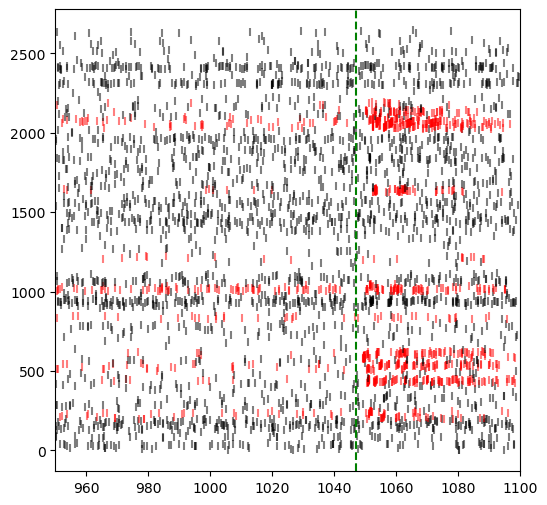

In [20]:
prev_event_count = 0
plt.close()
plt.figure(figsize=(6, 6))
for i, (key, event_time) in enumerate(RAW_DATA.items()):
    p_val = combined_results.loc[key, "p"]
    c = 'r' if p_val < 0.05 else 'k'
    if len(event_time) > 0:
        plt.scatter(event_time[:, 1], event_time[:, 0] + (i*25), alpha=0.5, marker='|', label='Event Times', c=c)
    #check if the date changes
    
plt.xlim([950, 1100])
plt.axvline(x=POST_TIME[0], color='g', linestyle='--', label='stim')
plt.show()

In [21]:


#load in metadata
metadata = pd.read_excel("Z:\\Molsrv\\Julia\\Data\\Opto\\Opto Perifornical for Grant_2025\\FILENAMES_Opto Perifornical_FOR_YEHOR.xlsx")



FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\Molsrv\\Julia\\Data\\Opto\\Opto Perifornical for Grant_2025\\FILENAMES_Opto Perifornical_FOR_YEHOR.xlsx'

In [ ]:
print(metadata.tail())

     Cell ID      Date Mouse ID Sex Condition Slice ID Well#     Filled?  \
101  5_SM_14       NaN    860-9   F       NaN      3-R   NaN  Not filled   
102  5_SM_15       NaN    860-9   F       NaN      2-R   NaN  Not filled   
103  5_SM_16       NaN    860-9   F       NaN      2-R   NaN  Not filled   
104  5_SM_17       NaN    860-9   F       NaN      2-R   NaN  Not filled   
105  2_SM_18  250807.0    863-9   M        KD      2-R   NaN  Not filled   

                Area Exerimenter  ...  PRE_21 PRE_22 PRE_23  PRE_24  POST_19  \
101       PF-lateral          SM  ...     0.0    0.0    0.0     0.0      0.0   
102   PF-dorsomedial          SM  ...     0.0    0.0    0.0     0.0      0.0   
103        PF-medial          SM  ...     0.0    0.0    0.0     0.0      1.0   
104  PF-dorsolateral          SM  ...     0.0    0.0    0.0     0.0      0.0   
105  PF-ventromedial          SM  ...     0.0    0.0    0.0     0.0      0.0   

     POST_20 POST_21 POST_22 POST_23 POST_24  
101      0.0   

In [ ]:
#join based on the "PP (20 ms)" column in metadata, and index in combined_results
combined_results_meta = combined_results.set_index("filename").join(metadata.set_index("PP (20 ms)"))

ValueError: columns overlap but no suffix specified: Index(['stat', 'p', 'abfID', 'sweepCount', 'pre_count_mean', 'post_count_mean',
       'pre_count_std', 'post_count_std', 'PRE_0', 'PRE_1', 'PRE_2', 'PRE_3',
       'PRE_4', 'PRE_5', 'PRE_6', 'PRE_7', 'PRE_8', 'PRE_9', 'PRE_10',
       'PRE_11', 'PRE_12', 'PRE_13', 'PRE_14', 'PRE_15', 'PRE_16', 'PRE_17',
       'PRE_18', 'PRE_19', 'PRE_20', 'PRE_21', 'PRE_22', 'PRE_23', 'PRE_24',
       'POST_0', 'POST_1', 'POST_2', 'POST_3', 'POST_4', 'POST_5', 'POST_6',
       'POST_7', 'POST_8', 'POST_9', 'POST_10', 'POST_11', 'POST_12',
       'POST_13', 'POST_14', 'POST_15', 'POST_16', 'POST_17', 'POST_18',
       'POST_19', 'POST_20', 'POST_21', 'POST_22', 'POST_23', 'POST_24'],
      dtype='object')

In [ ]:
combined_results_meta.to_csv(os.path.join(MAIN_FOLDER, "combined_results_with_metadata.csv"))